# Queue

In [1]:
import os
import sys

sys.path.append("../")

In [2]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons, make_circles
import seaborn as sns
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Function
from torchviz import make_dot

from src.ml.sinkhorn import pot_sinkhorn

In [3]:
sns.set(style="whitegrid")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset generation

In [5]:
n_features = 512
n_clusters = 128
batch_size = 64
n_samples = 2000

In [24]:
class ToyDataset(Dataset):
    def __init__(self, n_features, n_clusters, n_samples):
        self.n_features = n_features
        self.n_clusters = n_clusters
        self.n_samples = n_samples
    
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y_true[idx]
    
    def plot(self):
        fig, ax = plt.subplots(
            nrows=1,
            ncols=1,
            figsize=(5, 5)
        )

        sns.scatterplot(  # plot first 2 components
            x=self.X[:, 0],
            y=self.X[:, 1],
            hue=map(str, self.y_true),
            ax=ax,
            legend=False
        )

        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_title("Clusters visualization")

        return fig


class BlobsDataset(ToyDataset):
    """
    https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
    """
    def __init__(self, n_features, n_clusters, n_samples):
        super().__init__(n_features, n_clusters, n_samples)
        
        X, y_true = make_blobs(
            n_samples=n_samples,
            n_features=n_features,
            centers=n_clusters,
            cluster_std=.8,
            random_state=0
        )
        
        self.X = torch.FloatTensor(X)
        self.y_true = torch.LongTensor(y_true)

In [25]:
dataset = BlobsDataset(n_features, n_clusters, n_samples)
dataloader = DataLoader(dataset, batch_size=batch_size)

## Model definition

In [26]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
        )
    
    def forward(self, inputs):
        mlp_out = self.mlp(inputs)
        softmax_out = nn.LogSoftmax(dim=1)(mlp_out)
        
        return softmax_out

## Queue implementation

- [x] stored_M (= previous batchs dans la queue)
- [x] M = current batch
- [x] tu rajoutes stored_M comme argument supplementaire à SinkhornValueFunc
- [x] sinkhorn est execute sur M_full = concatenation de M et stored_M
- [x] puis dans SinkhornValue tu implemente la logique de storer les M quand tu call la fonction, avec une logique de queue FIFO 
- [x] et pas besoin d'utiliser une queue pour cela, juste un tensor me semble suffisant, juste quand tu arrives à la limite de taille, pour inserer le nouveau batch, tu "roll" le tensor


In [27]:
model = Model(
    input_dim=n_features,
    output_dim=n_clusters
)

In [28]:
stored_M = torch.Tensor()   # tensor acts as queue
max_n_batches_in_queue = 2  # max number of batches in queue

for batch_ix, (inputs, labels) in enumerate(dataloader):
    # M is model output
    M = model(nn.functional.normalize(inputs))
    
    #################
    # Sinkhorn step #
    #################
    M_concat = torch.cat([M, stored_M])
    
    # Compute marginals
    a = torch.ones(M_concat.shape[0])
    b = torch.ones(M_concat.shape[1]) * (M.shape[0] / M.shape[1])
    
    # Compute sinkhorn
    P = pot_sinkhorn(M_concat, a, b, epsilon=0.1, method="sinkhorn_log")

    ################ 
    # Update queue #
    ################
    
    if max_n_batches_in_queue > 0:
        # Update stored M
        n_batches_in_queue = stored_M.shape[0] / batch_size
        if  n_batches_in_queue < max_n_batches_in_queue:
            # Append current batch to previous batches
            stored_M = M_concat
        else:
            # Roll stored M, older batch comes first, replace it with M
            stored_M = torch.roll(stored_M, batch_size, 0)  # roll, first batch is the oldest
            stored_M[:batch_size, :] = M                    # update first batch with new one
    
    # Print for debug
    print("Batch {0}: {1}".format(batch_ix, stored_M.shape))
    
    if batch_ix == 10:
        break

/Users/eric/Code/virtualenvs/data-science/lib/python3.7/site-packages/ot/bregman.py:723: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Batch 0: torch.Size([64, 128])
Batch 1: torch.Size([128, 128])
Batch 2: torch.Size([128, 128])
Batch 3: torch.Size([128, 128])
Batch 4: torch.Size([128, 128])
Batch 5: torch.Size([128, 128])
Batch 6: torch.Size([128, 128])
Batch 7: torch.Size([128, 128])
Batch 8: torch.Size([128, 128])
Batch 9: torch.Size([128, 128])
Batch 10: torch.Size([128, 128])


## Queue integration

In [37]:
class SinkhornValueFunc(Function):
    @staticmethod
    def forward(ctx, M, stored_M, a, b, epsilon, solver, solver_options):
        # Concat M and stored_M from the queue
        # Note: stored_M is empty when the queue is ignored
        #       in this case, M_concat = M
        M_concat = torch.cat([M, stored_M])

        # Run Sinkhorn on concatenation between M and queue
        P = solver(
            M_concat.detach(),
            a,
            b,
            epsilon,
            **solver_options
        )

        # Take only P rows from current batch
        P = P[:M.shape[0], :]

        log_P = P.log().clamp(min=-100)
        H = - (P * log_P).sum()
        value_OT = (P*M).sum() - epsilon*H

        ctx.save_for_backward(P)
        return value_OT

    @staticmethod
    def backward(ctx, grad_output):
        P, = ctx.saved_tensors
        grad_M = P * grad_output

        return grad_M, None, None, None, None, None, None


class SinkhornValue(nn.Module):
    """Sinkhorn value.

    Returns optimal value for the regularized OT problem:
        L(M) = min <M, P> - \epsilon H[P] s.t. \sum_j P_ij = a_i and \sum_i P_ij = b_j
    with entropy H[P] = - \sum_ij P_ij log(P_ij)

    Args:
        epsilon (float): regularization parameter
        solver (function): OT solver
        solver_kwargs (int): options to pass to the solver
    """
    def __init__(self, epsilon, max_n_batches_in_queue, solver,
                 **solver_options):
        super().__init__()
        # Sinkhorn params
        self.epsilon = epsilon
        self.solver = solver
        self.solver_options = solver_options

        # Queue params
        self.stored_M = torch.Tensor().to(device)  # tensor acts as queue
        # Maximum number of batches to store in queue, set to 0 for no queue
        self.max_n_batches_in_queue = max_n_batches_in_queue

    def forward(self, M):
        batch_size = M.shape[0]
        M = M.to(device)

        #################
        # Sinkhorn step #
        #################
        # Compute marginals
        with torch.no_grad():
            M_concat = torch.cat([M, self.stored_M]).to(device)
            # a has batch_size len
            a = torch.ones(M_concat.shape[0]).to(device)
            # b has n_clusters len
            b = (torch.ones(M_concat.shape[1]) * (M_concat.shape[0] / M_concat.shape[1])).to(device)

        # Compute sinkhorn
        loss = SinkhornValueFunc.apply(
            M,                   # current batch M
            self.stored_M,       # M stored in queue
            a,                   # batch size marginal
            b,                   # cluster size marginal
            self.epsilon,        # sinkhorn entropy
            self.solver,         # sinkhorn solver
            self.solver_options  # sinkhorn solver options
        )

        # if queue len > 0, use the queue, otherwise don't
        if self.max_n_batches_in_queue > 0:
            ################
            # Update queue #
            ################
            with torch.no_grad():
                # get current number of batches in queue
                n_batches_in_queue = self.stored_M.shape[0] / batch_size

                # if current n batches < max batches
                if n_batches_in_queue < self.max_n_batches_in_queue:
                    # Append current batch to previous batches
                    self.stored_M = M_concat
                else:
                    # Roll stored M by a batch size
                    self.stored_M = torch.roll(self.stored_M, batch_size, 0)
                    # Oldest batch is now first, replace it with current M
                    self.stored_M[:batch_size, :] = M

        # return loss value on current M
        return loss

    def extra_repr(self):
        return (
            f"epsilon={self.epsilon:.2e}, solver={self.solver},"
            "solver_options={self.solver_options}"
        )


In [230]:
# Define model
model = Model(
    input_dim=n_features,
    output_dim=n_clusters
)
assert model.mlp[0].in_features == n_features
assert model.mlp[-1].out_features == n_clusters


# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


# Define loss
SV = SinkhornValue(
    epsilon=.2,
    solver=pot_sinkhorn,
    max_n_batches_in_queue=2,
    method="sinkhorn_log",
    numItermax=100,
    warn=True
)
assert SV.solver == pot_sinkhorn
assert SV.solver_options.get("method") == "sinkhorn_log"
assert SV.solver_options.get("numItermax") == 100
assert SV.solver_options.get("warn") == True
assert isinstance(SV.stored_M, torch.Tensor)
assert SV.stored_M.shape[0] == 0


# Input data
X, y = next(iter(dataloader))
X_norm = nn.functional.normalize(X)
assert X_norm.shape == (batch_size, n_features)
assert round(torch.norm(X_norm[1]).item(), ndigits=4) == 1.
assert y.shape[0] == batch_size


# Forward pass
optimizer.zero_grad()
M = model(X_norm)
assert M.shape == (batch_size, n_clusters)
assert all(torch.round(torch.exp(M).sum(axis=1)) == 1.)
assert torch.exp(M).min() >= 0
assert torch.exp(M).max() <= 1


# Marginals
a = torch.ones(M.shape[0])
b = torch.ones(M.shape[1]) * (M.shape[0] / M.shape[1])
assert a.shape[0] == batch_size
assert all(a == torch.ones(batch_size))
assert b.shape[0] == n_clusters
assert all(b == batch_size / n_clusters)


# Sinkhorn solver
P = pot_sinkhorn(M=-M, a=a, b=b, epsilon=SV.epsilon, **SV.solver_options)
assert all(np.round(P.sum(axis=1).data.numpy(), 2) == 1.)
assert all(np.round(P.sum(axis=0).data.numpy(), 2) == 0.5)


# Compute loss
log_P = P.log().clamp(min=-100)
H = - (P * log_P).sum()
value_OT = (P*-M).sum() - SV.epsilon*H

In [245]:
(P*-M).sum()

tensor(310.5510, grad_fn=<SumBackward0>)

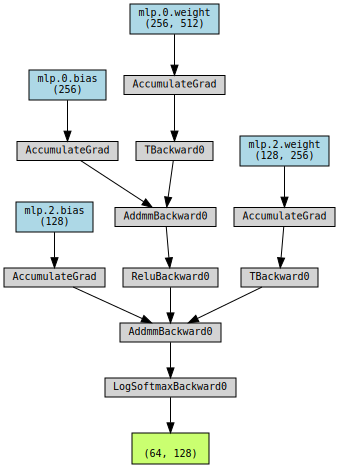

In [237]:
# computational graph
make_dot(M, params=dict(list(model.named_parameters())))